## Libraries

In [1]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

d:\AI_Repositories_2\Pytorch\pytorch1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Loading

We used the dataset restaurant reviews from kaggle.com. (Link: https://www.kaggle.com/code/latifar/restaurant-reviews/notebook). This Dataset have 10,000 datapoints. This dataset includes various features such as:


- Restaurant: The name of the restaurant being reviewed.

- Reviewer: The individual who provided the review.

- Review: The textual content of the review.

- Rating: The rating given by the reviewer, which may include numeric values (e.g., 1-5) and non-numeric entries like 'Like'.

- Metadata: Additional information related to the review.

- Time: Timestamp indicating when the review was made.

- Pictures: Images associated with the review.

We do not need all of the columns of this dataset for our sentiment prediction model. We will drop irrelevant columns and we will also do preprocessing methods to maintain data quality.



In [2]:
df = pd.read_csv("Restaurant reviews.csv", encoding='ISO-8859-1')

In [3]:
df.head()


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


By dropping the columns below, we streamlined the dataset to focus only on the review text and its associated sentiment label, improving model efficiency and interpretability.

## Data Preprocessing

In [4]:
df = df.drop(columns=(['Restaurant','Reviewer','Metadata','Time','Pictures','7514']))

We examined the unique values in the Rating column and found that some entries are non-numeric, such as 'Like' and NaN. These inconsistent values need to be cleaned or converted during preprocessing to ensure the model can interpret the ratings correctly. Proper handling of these values improves both model accuracy and data integrity.

In [5]:
df['Rating'].unique()

array(['5', '4', '1', '3', '2', '3.5', '4.5', '2.5', '1.5', 'Like', nan],
      dtype=object)

We replaced the value 'Like' with 4. We assumed that the Like value suggest a positive rating.

In [6]:
df['Rating'] = df['Rating'].replace('Like', 4)

We dropped rows with missing values in the Rating and Review columns to ensure data completeness. Removing null entries helps maintain data quality and improves the reliability of the model's training process.

In [7]:
df = df.dropna(subset=['Rating'])

In [8]:
df = df.dropna(subset=["Review"])

We converted the Rating values to float data type using astype(float) to ensure consistent numerical formatting, which is essential for further processing and modeling.

In [9]:
df['Rating'] = df['Rating'].astype(float)

The map_sentiment function is used to transform numerical ratings into categorical sentiment labels for easier sentiment analysis or classification tasks. Ratings less than 3 are labeled as "negative", ratings equal to 3 are "neutral", and ratings from 4 to 5 are labeled as "positive".

In [10]:
def map_sentiment(label):
    if label >= 4:
        return "positive"
    elif label >=3:
        return "neutral"
    elif label < 3:
        return "negative"

# Apply the function to create a new sentiment column
df["Rating"] = df["Rating"].apply(map_sentiment)

# Optional: View the distribution
print(df["Rating"].value_counts())

Rating
positive    6269
negative    2447
neutral     1239
Name: count, dtype: int64


The bar chart shows the class distribution of sentiment categories derived from the restaurant review ratings. The positive class dominates the dataset with 6,269 samples, followed by 2,447 negative reviews and only 1,239 neutral ones. This significant imbalance indicates a strong skew toward positive sentiments, which may reflect a bias in user-submitted reviews. 

To build a robust model, we need to address this imbalance carefully. Instead of undersampling the positive class or oversampling the minority classes, we should explore alternative techniques such as class weighting to ensure effective use of all available data points.

<Axes: xlabel='Rating'>

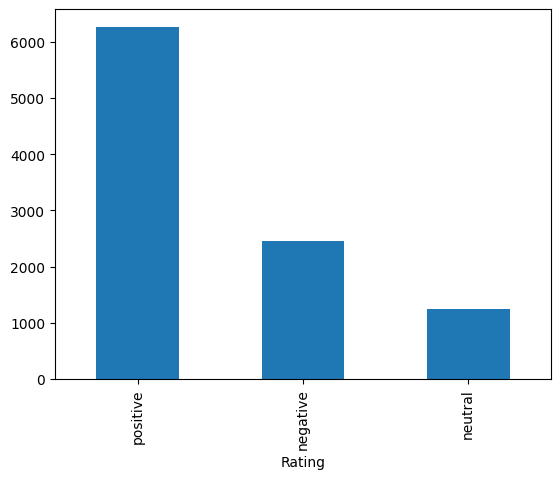

In [11]:
df['Rating'].value_counts().plot(kind='bar')


function clean_text ensures the review text is clean, consistent, and simplified. We are removing extra spaces and unwanted symbols in the review column.

In [12]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s.,!?']", '', text)  # keep punctuation useful for sentiment
    text = re.sub(r"\s+", ' ', text).strip()
    return text

df["Review"] = df["Review"].astype(str).apply(clean_text)


The code block below maps the sentiment labels (negative, neutral, positive) to numeric values (0, 1, 2) to prepare them for model training. It also ensures the review content is treated as string type and renames the Review column to text, which is a common convention in NLP tasks.

In [13]:
# Map sentiment to numeric labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df["label"] = df["Rating"].map(label_map)

df["Review"] = df["Review"].astype(str)
df = df.rename(columns={"Review": "text"})


## Train, Validation, Test Split

We used an 80/10/10 split for training, validation and test dataset. We used Stratify to ensure that all sentiment classes remain proportionally represented in each split.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


# Train/val/test split
train_df, temp_df = train_test_split(df, stratify=df["label"], test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, stratify=temp_df["label"], test_size=0.5, random_state=42)


# Check label distribution
print("Train distribution:\n", train_df["Rating"].value_counts())
print("Val distribution:\n", val_df["Rating"].value_counts())
print("Test distribution:\n", test_df["Rating"].value_counts())





Train distribution:
 Rating
positive    5015
negative    1958
neutral      991
Name: count, dtype: int64
Val distribution:
 Rating
positive    627
negative    244
neutral     124
Name: count, dtype: int64
Test distribution:
 Rating
positive    627
negative    245
neutral     124
Name: count, dtype: int64


We now convert the train,validation and test splits into huggingface dataset objects. 

In [15]:
train_dataset = Dataset.from_pandas(train_df[["text", "label"]])
val_dataset = Dataset.from_pandas(val_df[["text", "label"]])
test_dataset = Dataset.from_pandas(test_df[["text", "label"]])

## Model Setup

In [16]:
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)


### Tokenizer

In [17]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

### Tokenize Fuction

This code tokenizes the text data in the train, validation, and test datasets using the tokenizer, applying padding and truncation to ensure uniform input lengths. The .map() function applies the tokenization in batches for efficiency. Finally, the datasets are formatted for use with PyTorch by specifying the required input columns: input_ids, attention_mask, and label.

In [18]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 996/996 [00:00<00:00, 3747.82 examples/s]


### Model Initialization

We use the pretrained model distilbert-base-uncased for sentiment classification, applying a custom dropout rate of 0.3 to reduce overfitting. This model is ideal because it is lightweight, efficient, and retains much of the performance of larger models like BERT while being faster and less resource-intensive. Using a pretrained transformer also allows us to leverage prior knowledge learned from a large corpus, improving accuracy even with limited labeled data.

In [19]:
from transformers import DistilBertConfig, AutoModelForSequenceClassification
config = DistilBertConfig.from_pretrained("distilbert-base-uncased", 
                                          num_labels=3,
                                          dropout=0.3)      # Custom dropout for hidden layers
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Class Imbalance Solution

To address the earlier issue of class imbalance, we manually assigned higher weights to the minority classes (negative and neutral) using the class_weights list. These weights ensure that the model gives more importance to underrepresented classes during training, reducing bias toward the majority (positive) class. The weights are converted into a PyTorch tensor to be used with the loss function.

We also experimented with different class weight combinations to find the optimal balance for model performance. After several trials, the weights [2.2, 2.3, 1.0] for negative, neutral, and positive classes respectively produced the best evaluation results, improving the model's ability to correctly classify minority classes. This manual tuning helped reduce bias and improved the overall fairness of the classification.

In [20]:
# Manual override: give more importance to negative and neutral
class_weights = [3.0, 3.3, 1.0]  # [negative=0, neutral=1, positive=2]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

### DistilBERT with Class-Weighted CrossEntropy Loss
This code defines a custom PyTorch model class, WeightedDistilBERT, which wraps a pretrained DistilBERT model and incorporates a class-weighted CrossEntropyLoss to handle class imbalance. During training, the model computes the loss using the provided class weights, giving more importance to underrepresented classes. This setup improves the model's ability to learn from imbalanced data and helps reduce bias toward the majority class.

In [21]:
from torch.nn import CrossEntropyLoss

# Define a custom model class that applies class weights
class WeightedDistilBERT(torch.nn.Module):
    def __init__(self, model, class_weights):
        super().__init__()
        self.model = model
        self.loss_fn = CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}


### Model Initialization with Device-Aware Class Weights

In [22]:
weighted_model = WeightedDistilBERT(model, class_weights_tensor.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")))


### Metrics Function

This function computes evaluation metrics for the model's predictions during validation or testing.This function computes accuracy, precision, recall, and F1-score.

In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

### Training Phase

The model will iterate over the entire training dataset 10 times. This is a reasonable starting point for fine-tuning and allows the model enough time to converge without overfitting.

We used a small learning rate because we are using a pretrained model. Lower LR will help us avoid large updates that could erase learned features of our pretrained model.

A batch size of 16 balances memory usage and convergence speed.

A small amount of L2 regularization is applied to prevent overfitting by penalizing large weights.

These hyperparameters were chosen to optimize training efficiency while preventing overfitting. We used a low learning rate and regularization to preserve pretrained knowledge from DistilBERT and ensure stable fine-tuning on our restaurant review dataset.



In [24]:
import evaluate
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=500,
)

# STEP 12: Train the Model

trainer = Trainer(
    model=weighted_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



trainer.train()

C:\Users\Wax\AppData\Local\Temp\ipykernel_21912\4235885911.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.591200
1000,0.448400
1500,0.372300
2000,0.315700
2500,0.254500
3000,0.216300
3500,0.191800
4000,0.164000
4500,0.148700


TrainOutput(global_step=4980, training_loss=0.28419462916362714, metrics={'train_runtime': 15792.6925, 'train_samples_per_second': 5.043, 'train_steps_per_second': 0.315, 'total_flos': 0.0, 'train_loss': 0.28419462916362714, 'epoch': 10.0})

### Validation Phase

During validation, the model achieved a strong accuracy of 85.03% and an F1-score of 85.42%, indicating high reliability and well-balanced performance across all classes. The relatively low validation loss (1.02) suggests effective learning and minimal overfitting.

In [25]:
trainer.evaluate(eval_dataset=val_dataset)


{'eval_loss': 1.016629934310913,
 'eval_accuracy': 0.8502512562814071,
 'eval_precision': 0.8589266363499677,
 'eval_recall': 0.8502512562814071,
 'eval_f1': 0.8541580395074078,
 'eval_runtime': 75.897,
 'eval_samples_per_second': 13.11,
 'eval_steps_per_second': 0.83,
 'epoch': 10.0}

### Testing Phase

The model achieved strong performance on the test set, with an accuracy of 84.34% and an F1-score of 84.48%, indicating balanced and consistent predictions across sentiment classes. The low loss value (1.07) suggests the model generalizes well to unseen data.


In [26]:
trainer.evaluate(test_dataset)

{'eval_loss': 1.0697822570800781,
 'eval_accuracy': 0.8433734939759037,
 'eval_precision': 0.8468368666975595,
 'eval_recall': 0.8433734939759037,
 'eval_f1': 0.844767714337081,
 'eval_runtime': 75.6384,
 'eval_samples_per_second': 13.168,
 'eval_steps_per_second': 0.833,
 'epoch': 10.0}

### Confusion Matrix

In [27]:
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
labels = predictions.label_ids

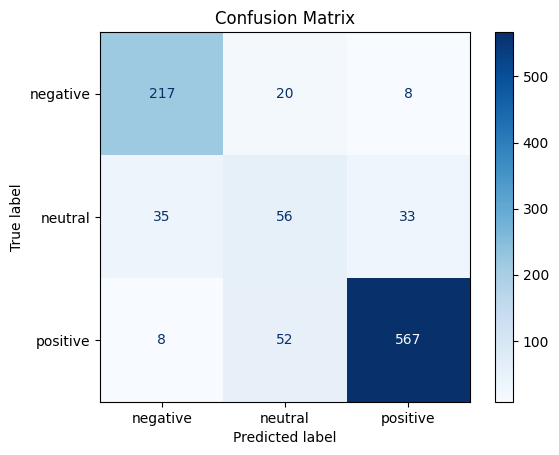

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

label_names = ['negative', 'neutral', 'positive']

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


The confusion matrix shows that the model performs well across all three sentiment classes (negative, neutral, and positive) with especially strong performance on the positive class.

Positive reviews are the most accurately predicted: 567 correctly out of ~627, with only 8 misclassified as negative and 52 as neutral.

Negative reviews are also handled well, with 217 correct predictions, and relatively low confusion with neutral (20) and positive (8).

Neutral reviews show the most confusion, with 56 correct, but 35 misclassified as negative and 33 as positive — indicating that neutral sentiment is more challenging for the model to distinguish.

This confusion matrix suggests that the model is highly reliable for detecting positive and negative sentiments, but there is room for improvement in distinguishing neutral reviews. Still, the overall distribution shows a balanced and accurate model, suitable for real-world deployment with additional fine-tuning if neutral precision is a priority.



The code below saves the fine-tuned model and its corresponding tokenizer to the ./best_sentiment_modelv3 directory. By calling .save_pretrained(), both the model weights and tokenizer configuration are stored in a format that can be easily reloaded later using from_pretrained(). This step is essential for deployment, sharing, or future inference without needing to retrain the model.

In [29]:
trainer.model.model.save_pretrained("./best_sentiment_modelv4")
tokenizer.save_pretrained("./best_sentiment_modelv4")


('./best_sentiment_modelv4\\tokenizer_config.json',
 './best_sentiment_modelv4\\special_tokens_map.json',
 './best_sentiment_modelv4\\vocab.txt',
 './best_sentiment_modelv4\\added_tokens.json',
 './best_sentiment_modelv4\\tokenizer.json')

In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("./best_sentiment_modelv4")
tokenizer = AutoTokenizer.from_pretrained("./best_sentiment_modelv4")


d:\AI_Repositories_2\Pytorch\pytorch1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Inference

The code below represents the inference phase, where the trained model is used to make predictions on new, unseen text data. It simulates how the model would perform in a real-world application by taking user input, processing it, and returning the predicted sentiment. 

In [31]:
import torch
# Load model to proper device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Define label mapping (reverse map)
inv_label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Inference function
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    return inv_label_map[prediction]

# Example usage

print(predict_sentiment("I love dining at Wolfgang Manila! The food is amazing and the service is top-notch. Highly recommend it to everyone!"))

positive


In [32]:
print(predict_sentiment("Jollibee offers a good appetizer, but the main course was a bit disappointing."))

neutral


### Spam Detection Function

This function is one of the features of our system, designed to detect whether a given input is spam or not. It helps ensure that the system only processes genuine restaurant reviews by filtering out irrelevant or spammy content. The function uses a pretrained BERT model specifically fine-tuned for spam classification.

We use the pretrained AventIQ-AI/bert-spam-detection model, which is built on the BERT base uncased architecture and fine-tuned specifically for spam detection tasks. This model was trained on datasets like the Hugging Face spam-mail and mail_spam_ham_dataset, achieving high performance with an accuracy and F1-score of around 99%. It is also quantized to float16, making it lightweight and efficient for real-time deployment.


In [33]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the tokenizer and model
model_name = "AventIQ-AI/bert-spam-detection"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Define the prediction function
def predict_spam(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()
    return "Spam" if prediction == 1 else "Not Spam"

In [34]:
print(predict_spam("Wolfgang Manila is the place I wont recommend to anyone! waiters are rude!"))

Not Spam


In [35]:
print(predict_spam("Do you want to win dollars? Hurry up and click this link to claim your prize! www.example.com"))

Spam


### Toxic Input Filter Function

This function helps maintain the safety, quality, and relevance of inputs in our system by filtering out abusive, harmful, or irrelevant content before it reaches the sentiment classifier or chatbot module.

We use Detoxify, a pretrained model based on BERT, designed specifically to detect various forms of toxic language such as insults, threats, hate speech, and profanity. The version used (Detoxify('original')) provides a toxicity score, and we flag inputs with a score above 0.5 as toxic.

In [36]:
from detoxify import Detoxify

# Initialize Detoxify once
tox_model = Detoxify('original')

def filter(text):
    # Run toxicity check
    tox_scores = tox_model.predict(text)
    is_toxic = tox_scores["toxicity"] > 0.5

    # Run spam detection
    is_spam = predict_spam(text) == "Spam"

    if is_toxic and is_spam:
        return "🚫 Your message was flagged as both toxic and spam."
    elif is_toxic:
        return "⚠️ Your message contains toxic language. Please be respectful."
    elif is_spam:
        return "⚠️ Your message appears to be spam. Please avoid promotional or misleading content."
    else:
        return "✅ Message accepted. How can I help you?"


In [37]:
print(filter("want to win a brand new car? click the link www.sample.com"))  # Should be accepted

⚠️ Your message appears to be spam. Please avoid promotional or misleading content.


### NER, Sentiment, and LIME Explanation Pipeline

This function is responsible for performing Named Entity Recognition (NER), Sentiment Classification, and generating explainability insights using LIME (Local Interpretable Model-Agnostic Explanations). It provides a full diagnostic on each restaurant review by extracting relevant entities (e.g., restaurant names, locations), classifying the overall sentiment, and identifying which specific words most influenced the model’s prediction. 

In [4]:
import spacy
from lime.lime_text import LimeTextExplainer

# Load spaCy model once
nlp = spacy.load("en_core_web_sm")

# Full analysis function
def analyze_review(text):
    print(f"\n🔍 Input: {text}\n")

    # NER
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    print(f"🏷️ Named Entities: {entities if entities else 'None'}")

    # SENTIMENT
    sentiment = predict_sentiment(text)
    print(f"💬 Sentiment: {sentiment.upper()}")

    # LIME
    explainer = LimeTextExplainer(class_names=['Negative', 'Neutral', 'Positive'])

    def predict_proba(texts):
        tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**tokens)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        return probs.cpu().numpy()

    print("📌 LIME Explanation (Top Contributing Words):")
    exp = explainer.explain_instance(text, predict_proba, num_features=2)
    for word, score in exp.as_list():
        print(f"   - {word}: {score:.3f}")

    return {
        "text": text,
        "entities": entities,
        "sentiment": sentiment,
    }


In [9]:

# 🧪 Example Analysis
analyze_review("I love dining at Wolfgang Manila! The food is amazing and the service is top-notch. Highly recommend it to everyone!")



🔍 Input: I love dining at Wolfgang Manila! The food is amazing and the service is top-notch. Highly recommend it to everyone!

🏷️ Named Entities: [('Wolfgang Manila', 'PERSON')]
💬 Sentiment: POSITIVE
📌 LIME Explanation (Top Contributing Words):
   - love: -0.000
   - everyone: -0.000


{'text': 'I love dining at Wolfgang Manila! The food is amazing and the service is top-notch. Highly recommend it to everyone!',
 'entities': [('Wolfgang Manila', 'PERSON')],
 'sentiment': 'positive'}

### Export to CSV Function

This function saves the output of the review analysis (e.g., text, sentiment, entities, timestamp) to a CSV file named restaurant_review_analysis.csv.

In [39]:
import pandas as pd
import os
from datetime import datetime

def save_review_to_csv(result, csv_path="restaurant_review_analysis.csv"):
    # Add timestamp to result
    result["created_at"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Convert to DataFrame
    df = pd.DataFrame([result])

    # Append to file (create if it doesn't exist)
    if not os.path.exists(csv_path):
        df.to_csv(csv_path, index=False)
        print(f"✅ CSV created and review saved.")
    else:
        df.to_csv(csv_path, mode='a', header=False, index=False)
        print(f"✅ Review appended to existing CSV.")


In [40]:
review_text = "Jollibee Recto is such a lovely place!"
result = analyze_review(review_text)
save_review_to_csv(result)



🔍 Input: Jollibee Recto is such a lovely place!

🏷️ Named Entities: [('Jollibee Recto', 'PERSON')]
💬 Sentiment: NEGATIVE
📌 LIME Explanation (Top Contributing Words):
   - Jollibee: -0.000
   - lovely: -0.000
✅ Review appended to existing CSV.
